# Waste Classification

- **Course:** Machine Learning and Deep Learning
- **Dataset:** RealWaste
- **Examiner** Somnath Mazumdar

**Authors:**  
- Moritz von Buchwaldt (Student Number: 175877)  
- Jasper Schwietring (Student Number: 175857)  
- Michael Webster (Student Number: 175868)  
- Moritz Kremmer (Student Number: 175862)

**Description:**
This project explores machine learning and deep learning models to classify landfill waste images (RealWaste dataset) into nine categories. The goal is to compare, fine-tune and evaluate models to improve classification accuracy.



### Imports

In [ ]:
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__")) if '__file__' in globals() else os.getcwd()

while not os.path.exists(os.path.join(notebook_dir, "README.md")) and notebook_dir != "/":
    notebook_dir = os.path.abspath(os.path.join(notebook_dir, ".."))

os.chdir(notebook_dir)
print("Working directory set to:", os.getcwd())

Working directory set to: /


In [ ]:
pip install -r requirements.txt

ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


In [ ]:
# Standard libraries
import os
import random
import shutil
import time
from collections import Counter

# Scientific and visualization libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# TensorFlow & Keras
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, mixed_precision
from tensorflow.keras.optimizers.schedules import CosineDecay
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Model, Input
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.regularizers import l2

# Keras Tuner
import keras_tuner as kt
from keras_tuner.tuners import RandomSearch

# Scikit-learn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC

In [ ]:
data_dir = os.path.join("..", "data", "RealWaste_original")

# Automatically download the dataset if not already present
if not os.path.exists(data_dir):
    print("Dataset not found. Downloading...")
    !bash ../scripts/download_data.sh

### Paths

In [ ]:
#Paths
train_folder = os.path.join("..", "data", "RealWaste_train")
augmented_train_folder = os.path.join("..", "data", "RealWaste_augmented_train")
val_folder = os.path.join("..", "data", "RealWaste_val")
test_folder = os.path.join("..", "data", "RealWaste_test")
model_dir = os.path.join("..", "data", "Models")

### Functions
- Used across various models

In [ ]:
#Evaluation metrics for CNN models
def evaluate_model(model, dataset, class_names, label_mode='int', title_prefix='', show_misclassified=True, show_confidence=True):
    y_true, y_pred = [], []
    confidences = []
    misclassified = []

    for img, label in dataset.unbatch():
        if label_mode == 'onehot':
            label = tf.argmax(label, axis=-1)

        true_label = label.numpy()
        logits = model.predict(tf.expand_dims(img, 0), verbose=0)

        probs = tf.nn.softmax(logits[0]).numpy()
        pred_label = np.argmax(probs)
        confidence = np.max(probs)

        y_true.append(true_label)
        y_pred.append(pred_label)
        confidences.append(confidence)

        if show_misclassified and pred_label != true_label:
            misclassified.append((img.numpy(), true_label, pred_label, confidence))

    # Classification Report
    print(f"\n{title_prefix} Classification Report:")
    print(classification_report(y_true, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    #Confidence Histogram
    if show_confidence:
        plt.figure(figsize=(6, 4))
        plt.hist(confidences, bins=20, color='orange', edgecolor='black')
        plt.title(f"{title_prefix} Prediction Confidence Distribution")
        plt.xlabel("Max Softmax Probability")
        plt.ylabel("Number of Predictions")
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    #Misclassified Example
    if show_misclassified and misclassified:
        misclassified.sort(key=lambda x: x[3], reverse=True)
        plt.figure(figsize=(15, 5))
        for i in range(min(5, len(misclassified))):
            img, true, pred, conf = misclassified[i]
            plt.subplot(1, 5, i + 1)


            if img.max() <= 1.0:
                img_display = (img * 255).astype("uint8")
            else:
                img_display = img.astype("uint8")

            plt.imshow(img_display)
            plt.title(f"True: {class_names[true]}\nPred: {class_names[pred]}\nConf: {conf:.2f}")
            plt.axis("off")
        plt.tight_layout()
        plt.show()

    return y_true, y_pred

In [ ]:
#Evaluation metrics for SVM model
def evaluate_svm_model(model, X, y, class_names, title_prefix='', show_misclassified=True, show_confidence=True):

    y_pred = model.predict(X)

    #Classification Report
    print(f"\n{title_prefix} Classification Report:")
    print(classification_report(y, y_pred, target_names=class_names))

    # Confusion Matrix
    cm = confusion_matrix(y, y_pred)
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f"{title_prefix} Confusion Matrix")
    plt.colorbar()
    tick_marks = np.arange(len(class_names))
    plt.xticks(tick_marks, class_names, rotation=45, ha='right')
    plt.yticks(tick_marks, class_names)

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j], ha="center", va="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

In [ ]:
#Computes class weights to input into model to deal with imbalances
def compute_class_weights_from_dataset(dataset):
    counter = Counter()
    for batch in dataset:
        labels = batch[1]
        for label in labels:
            counter[int(label.numpy())] += 1

    total = sum(counter.values())
    num_classes = len(counter)

    class_weight = {
        cls_id: total / (num_classes * count)
        for cls_id, count in counter.items()
    }

    return class_weight

In [ ]:
#Used to add augmented images to the training set
def apply_augmentation(img, aug_type):
    if aug_type == "flip":
        img = tf.image.flip_left_right(img)

    elif aug_type == "rotate":
        angle = random.uniform(-30, 30)
        img = tf.cast(img, tf.uint8)
        img_pil = Image.fromarray(img.numpy())
        img_pil = img_pil.rotate(angle, resample=Image.BICUBIC, expand=True)
        img_pil = img_pil.resize((500, 500))
        img = tf.keras.utils.img_to_array(img_pil)

    elif aug_type == "brightness":
        img = tf.image.random_brightness(img, max_delta=0.3)

    elif aug_type == "crop":
        img = tf.image.central_crop(img, central_fraction=0.8)
        img = tf.image.resize(img, [500, 500])

    elif aug_type == "noise":
        noise = tf.random.normal(shape=tf.shape(img), mean=0.0, stddev=15.0)
        img = img + noise
        img = tf.clip_by_value(img, 0.0, 255.0)

    return img

In [ ]:
#Evaluate computational efficiency
def evaluate_cnn_efficiency(model, model_name, test_data, batch_size=32, input_shape=(256, 256, 3)):
    dummy_input = tf.random.normal([1, *input_shape])
    start_time = time.time()
    _ = model.predict(dummy_input, verbose=0)
    end_time = time.time()
    inference_time_ms = (end_time - start_time) * 1000

    param_count = model.count_params()

    # Evaluate on test set
    test_loss, test_acc = model.evaluate(test_data, batch_size=batch_size, verbose=0)

    return {
        "Model": model_name,
        "Accuracy (%)": round(test_acc * 100, 2),
        "Parameters (K)": round(param_count / 1e3, 2),
        "Inference Time (ms)": round(inference_time_ms, 2)
    }


In [ ]:
#Plot training history
def plot_training_history(history, title="Training History"):
    plt.figure(figsize=(12, 4))

    # Accuracy plot
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Acc')
    plt.plot(history.history['val_accuracy'], label='Val Acc')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Loss plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Val Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()


# Exploratory Data Analysis (EDA)
- To further understand our waste image dataset

In [ ]:
#Load dataset
waste_images = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    image_size=(500, 500), #500x500 (original size)
    batch_size=32,
    shuffle=True
)

Found 4752 files belonging to 9 classes.


In [ ]:
#Class names
class_names = waste_images.class_names
print("Classes:", class_names)

Classes: ['Cardboard', 'Food Organics', 'Glass', 'Metal', 'Miscellaneous Trash', 'Paper', 'Plastic', 'Textile Trash', 'Vegetation']


In [ ]:
#Class distribution
label_counts = Counter()
for _, labels in waste_images.unbatch():
    label_counts[int(labels.numpy())] += 1
for i, class_name in enumerate(class_names):
    print(f"{class_name}: {label_counts[i]}")

Cardboard: 461
Food Organics: 411
Glass: 420
Metal: 790
Miscellaneous Trash: 495
Paper: 500
Plastic: 921
Textile Trash: 318
Vegetation: 436


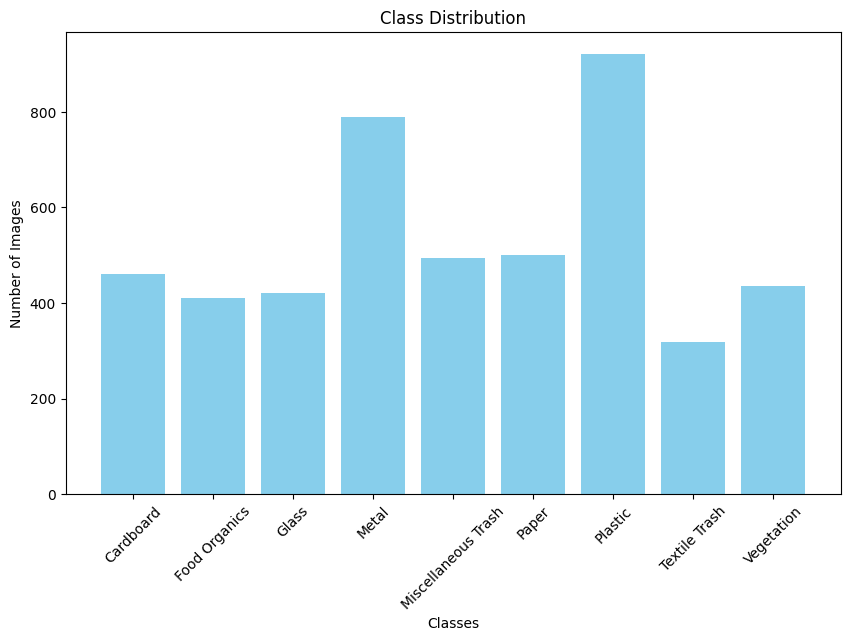

In [ ]:
counts = [label_counts[i] for i in range(len(class_names))]
plt.figure(figsize=(10, 6))
plt.bar(class_names, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Number of Images')
plt.title('Class Distribution')
plt.xticks(rotation=45)
plt.show()

Pixels
- Images are relatively bright (skewed to the left) and consistent (around 0.7)

In [ ]:
#Pixel statistics
all_pixels = []
for images, _ in waste_images.take(10): # Take 10 batches
    all_pixels.append(images.numpy())
all_pixels = np.concatenate(all_pixels).astype("float32") / 255.0
print("Shape:", all_pixels.shape)
print("Mean pixel value:", np.mean(all_pixels))
print("Std deviation of pixels:", np.std(all_pixels))


Shape: (320, 500, 500, 3)
Mean pixel value: 0.61448765
Std deviation of pixels: 0.17321959


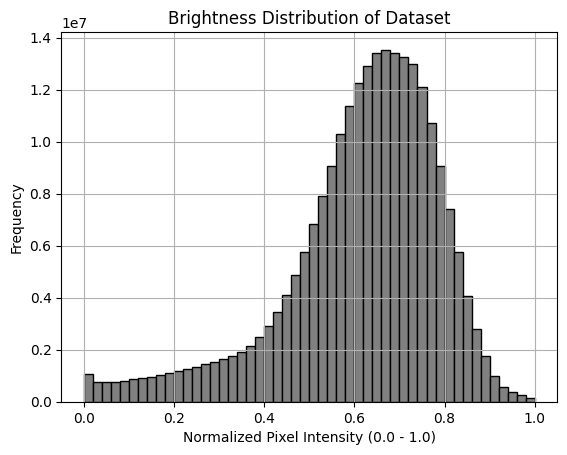

In [ ]:
flattened_pixels = all_pixels.flatten()

plt.hist(flattened_pixels, bins=50, color='gray', edgecolor='black')
plt.title("Brightness Distribution of Dataset")
plt.xlabel("Normalized Pixel Intensity (0.0 - 1.0)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()

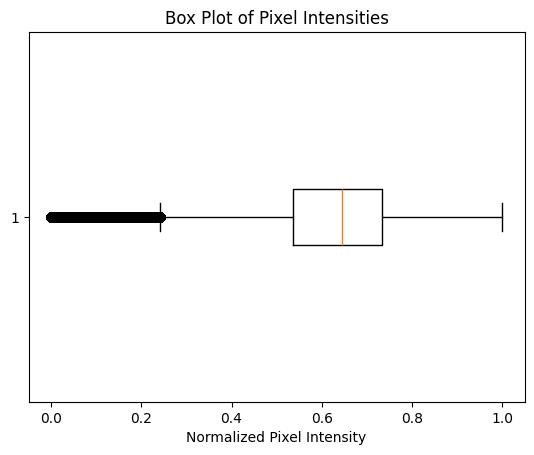

In [ ]:
plt.boxplot(flattened_pixels, vert=False)
plt.title("Box Plot of Pixel Intensities")
plt.xlabel("Normalized Pixel Intensity")
plt.show()

Aspect rations
- All are the same

In [ ]:
aspect_ratios = []

for images, _ in waste_images.take(10):
    for img in images.numpy():
        h, w = img.shape[0], img.shape[1]
        ratio = w / h
        aspect_ratios.append(ratio)
aspect_ratios = np.array(aspect_ratios)
print("Mean aspect ratio:", np.mean(aspect_ratios))
print("Standard deviation:", np.std(aspect_ratios))

Mean aspect ratio: 1.0
Standard deviation: 0.0


Miscellaneous Trash class
- Hard to define

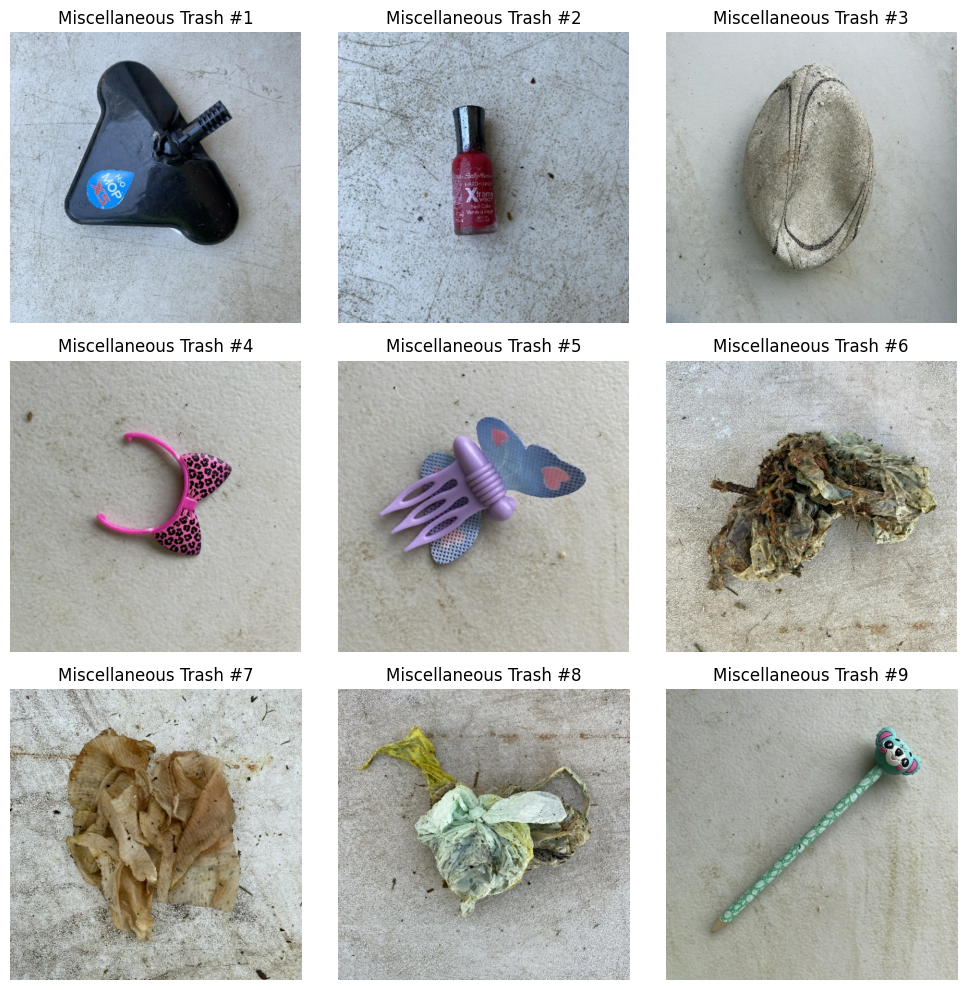

In [ ]:
MISC_INDEX = class_names.index('Miscellaneous Trash')

plt.figure(figsize=(10, 10))
shown = 0

for images, labels in waste_images:
    for i in range(len(images)):
        if labels[i].numpy() == MISC_INDEX:
            ax = plt.subplot(3, 3, shown + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(f"Miscellaneous Trash #{shown + 1}")
            plt.axis("off")
            shown += 1
            if shown == 9:
                break
    if shown == 9:
        break

plt.tight_layout()
plt.show()


# Splitting the dataset
- 70% train, 15% validation and 15% test
- Dataset split before augmentation to avoid data leakage

In [ ]:
source_folder = data_dir

In [ ]:
#Create destination folders
for d in (train_folder, val_folder, test_folder):
    if os.path.isdir(d):
        shutil.rmtree(d)
    os.makedirs(d, exist_ok=True)

#Split the dataset into train, val, and test sets
for cls in sorted(os.listdir(source_folder)):
    cls_src = os.path.join(source_folder, cls)
    if not os.path.isdir(cls_src):
        continue

    files = [f for f in os.listdir(cls_src) if f.lower().endswith(('.jpg', '.jpeg', '.png'))]
    bases = {}
    for f in files:
        base = os.path.splitext(f)[0]
        if base not in bases:
            bases[base] = []
        bases[base].append(f)

    #Shuffle
    random.seed(123)
    base_names = list(bases.keys())
    random.shuffle(base_names)

    n = len(base_names)
    n_train = int(0.7 * n)
    n_val = int(0.15 * n)
    train_bases = base_names[:n_train]
    val_bases = base_names[n_train:n_train + n_val]
    test_bases = base_names[n_train + n_val:]

    #Copy files to the folders
    for base_list, dst_folder in [(train_bases, train_folder), (val_bases, val_folder), (test_bases, test_folder)]:
        for base in base_list:
            dst = os.path.join(dst_folder, cls)
            os.makedirs(dst, exist_ok=True)
            for f in bases[base]:
                shutil.copy2(os.path.join(cls_src, f), os.path.join(dst, f))

    print(f"{cls}: {len(train_bases)} train, {len(val_bases)} val, {len(test_bases)} test")

print("Done")

Cardboard: 322 train, 69 val, 70 test
Food Organics: 287 train, 61 val, 63 test
Glass: 294 train, 63 val, 63 test
Metal: 553 train, 118 val, 119 test
Miscellaneous Trash: 346 train, 74 val, 75 test
Paper: 350 train, 75 val, 75 test
Plastic: 644 train, 138 val, 139 test
Textile Trash: 222 train, 47 val, 49 test
Vegetation: 305 train, 65 val, 66 test
Done


# Adding augmented images
- Due to similarities in images (brightness, aspect ratio, size), augmented images are added to the training set to further recognise patterns
- Types of augmentations include
  - Flip - image mirrored horizontially
  - Rotate - image rotated randomly between -30 and +30 degrees
  - Brightness - randomly adjusted between +-30%
  - Crop - crops images to 80% and resized (zooms)
  - Noise - adds random noise to each pixel
- Keep at original 500x500 size - will use different size inputs in different models

In [ ]:
#Copy the original training set to a new folder for augmentation
original_train = train_folder
augmented_train = augmented_train_folder

if os.path.exists(augmented_train):
    shutil.rmtree(augmented_train)

shutil.copytree(original_train, augmented_train)
print(f"Copied {original_train} to {augmented_train} for augmentation.\n")


Copied /content/data/RealWaste_train to /content/data/RealWaste_augmented_train for augmentation.



In [ ]:
augmentations = ["flip", "rotate", "brightness", "crop", "noise"]

In [ ]:
for class_name in os.listdir(augmented_train):
    class_path = os.path.join(augmented_train, class_name)
    if not os.path.isdir(class_path):
        continue

    print(f"Processing class: {class_name}")

    for filename in os.listdir(class_path):
        base_name, ext = os.path.splitext(filename)

        # Skip already augmented files
        if any(base_name.endswith(f"_{aug}") for aug in augmentations):
            continue

        file_path = os.path.join(class_path, filename)
        try:
            img = tf.keras.utils.load_img(file_path, target_size=(500, 500))
            img = tf.keras.utils.img_to_array(img)

            for aug in augmentations:
                aug_img = apply_augmentation(img, aug)
                aug_img = tf.cast(aug_img, tf.uint8)
                aug_pil = Image.fromarray(aug_img.numpy())
                new_filename = f"{base_name}_{aug}{ext}"
                aug_pil.save(os.path.join(class_path, new_filename))

        except Exception as e:
            print(f"Error processing {filename} in {class_name}: {e}")

print(f"Augmented images saved to: {augmented_train}")

Processing class: Metal
Processing class: Cardboard
Processing class: Plastic
Processing class: Vegetation
Processing class: Miscellaneous Trash
Processing class: Textile Trash
Processing class: Paper
Processing class: Food Organics
Processing class: Glass
Augmented images saved to: /content/data/RealWaste_augmented_train


# CNN1 - basic CNN

- Using a standard CNN structure to test our dataset
- LENET-5+VGG inspired - 4 conv layers + 1 dense layer
- Image size - 200x200
- Batch size - 20
- LR - Adam default (0.001)
- Adjusted for class weights (to deal with imbalance)
- Epochs - 40 (with early_stopping on val_loss with patience 5)
- ReduceLROnPlateau patience 3

In [ ]:
mixed_precision.set_global_policy("float32")

In [ ]:
#Paths and parameters
optimizer_cnn1 = tf.keras.optimizers.Adam()
train_cnn1 = augmented_train_folder
val_cnn1 = val_folder
test_cnn1 = test_folder
model_name = 'CNN1'
model_cnn1_path = os.path.join(model_dir, f"{model_name}.keras")

image_size_cnn1 = (200, 200)
batch_size_cnn1 = 20
epochs_cnn1 = 40

In [ ]:
#Load the datasets
train_ds_obj_cnn1 = tf.keras.utils.image_dataset_from_directory(
    train_cnn1,
    seed=123,
    image_size=image_size_cnn1,
    batch_size=batch_size_cnn1
)

val_ds_obj_cnn1 = tf.keras.utils.image_dataset_from_directory(
    val_cnn1,
    seed=123,
    image_size=image_size_cnn1,
    batch_size=batch_size_cnn1
)

test_ds_obj_cnn1 = tf.keras.utils.image_dataset_from_directory(
    test_cnn1,
    seed=123,
    image_size=image_size_cnn1,
    batch_size=batch_size_cnn1
)

test_class_names_cnn1 = test_ds_obj_cnn1.class_names
num_classes_cnn1 = len(test_class_names_cnn1)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_cnn1 = (train_ds_obj_cnn1.shuffle(buffer_size=1000).cache().prefetch(buffer_size=AUTOTUNE)) #only shuffle the training set
val_ds_cnn1   = val_ds_obj_cnn1.cache().prefetch(AUTOTUNE)
test_ds_cnn1  = test_ds_obj_cnn1.cache().prefetch(AUTOTUNE)

Found 19938 files belonging to 9 classes.
Found 710 files belonging to 9 classes.
Found 719 files belonging to 9 classes.


In [ ]:
cnn1_model = models.Sequential([
    layers.Input(shape=(image_size_cnn1[0], image_size_cnn1[1], 3)),
    layers.Rescaling(1./255),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_classes_cnn1)
])

cnn1_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 200, 200, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 198, 198, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 99, 99, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 97, 97, 32)     │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 46, 46, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 21, 21, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     1,638,528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,737,129 (6.63 MB)

 Trainable params: 1,737,129 (6.63 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
#Compile the model
cnn1_model.compile(
    optimizer=optimizer_cnn1,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Class weights
class_weight_cnn1 = compute_class_weights_from_dataset(train_ds_cnn1)
print("Class weights:", class_weight_cnn1)

Class weights: {7: 1.6631631631631631, 6: 0.5733264320220842, 3: 0.6676712879244525, 5: 1.0549206349206348, 4: 1.067116249197174, 1: 1.286488579171506, 0: 1.1466528640441684, 8: 1.2105646630236795, 2: 1.2558578987150415}


In [ ]:
#Callbacks
cb_cnn1 = [
    callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1),
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(model_cnn1_path, monitor='val_accuracy',save_best_only=True, verbose=1)
]

In [ ]:
#Fit the model
history_cnn1 = cnn1_model.fit(train_ds_cnn1, validation_data=val_ds_cnn1, epochs=epochs_cnn1, callbacks=cb_cnn1, class_weight=class_weight_cnn1)

Epoch 1/40
990/997 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.2922 - loss: 1.8540
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to /content/data/Models/CNN1.keras
997/997 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.2929 - loss: 1.8522 - val_accuracy: 0.5000 - val_loss: 1.3471 - learning_rate: 0.0010
Epoch 2/40
995/997 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5089 - loss: 1.2733
Epoch 2: val_accuracy improved from 0.50000 to 0.59718, saving model to /content/data/Models/CNN1.keras
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5089 - loss: 1.2732 - val_accuracy: 0.5972 - val_loss: 1.0336 - learning_rate: 0.0010
Epoch 3/40
996/997 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.5890 - loss: 1.0717
Epoch 3: val_accuracy improved from 0.59718 to 0.64225, saving model to /content/data/Models/CNN1.keras
997/997 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - accuracy: 0.5890 - loss: 1.0716 - val_accuracy: 0.6423 - val_loss: 0.9925 - learning_rate: 0.0010
Epoch 4/

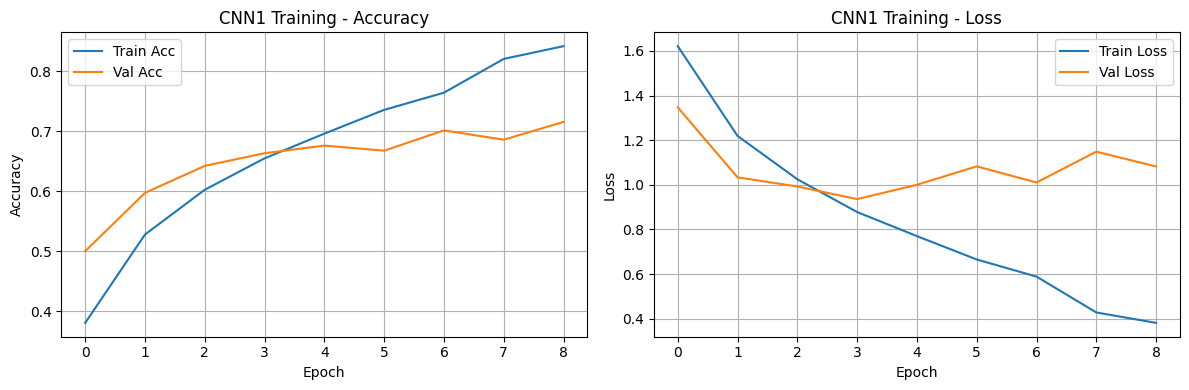

In [ ]:
plot_training_history(history_cnn1, title="CNN1 Training")

 ### CNN1 evaluation

In [ ]:
cnn1_model_best = load_model(model_cnn1_path)


Validation Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.77      0.74      0.76        69
      Food Organics       0.78      0.87      0.82        61
              Glass       0.79      0.71      0.75        63
              Metal       0.66      0.78      0.71       118
Miscellaneous Trash       0.45      0.46      0.46        74
              Paper       0.73      0.71      0.72        75
            Plastic       0.77      0.72      0.74       138
      Textile Trash       0.65      0.47      0.54        47
         Vegetation       0.87      0.91      0.89        65

           accuracy                           0.72       710
          macro avg       0.72      0.71      0.71       710
       weighted avg       0.72      0.72      0.71       710



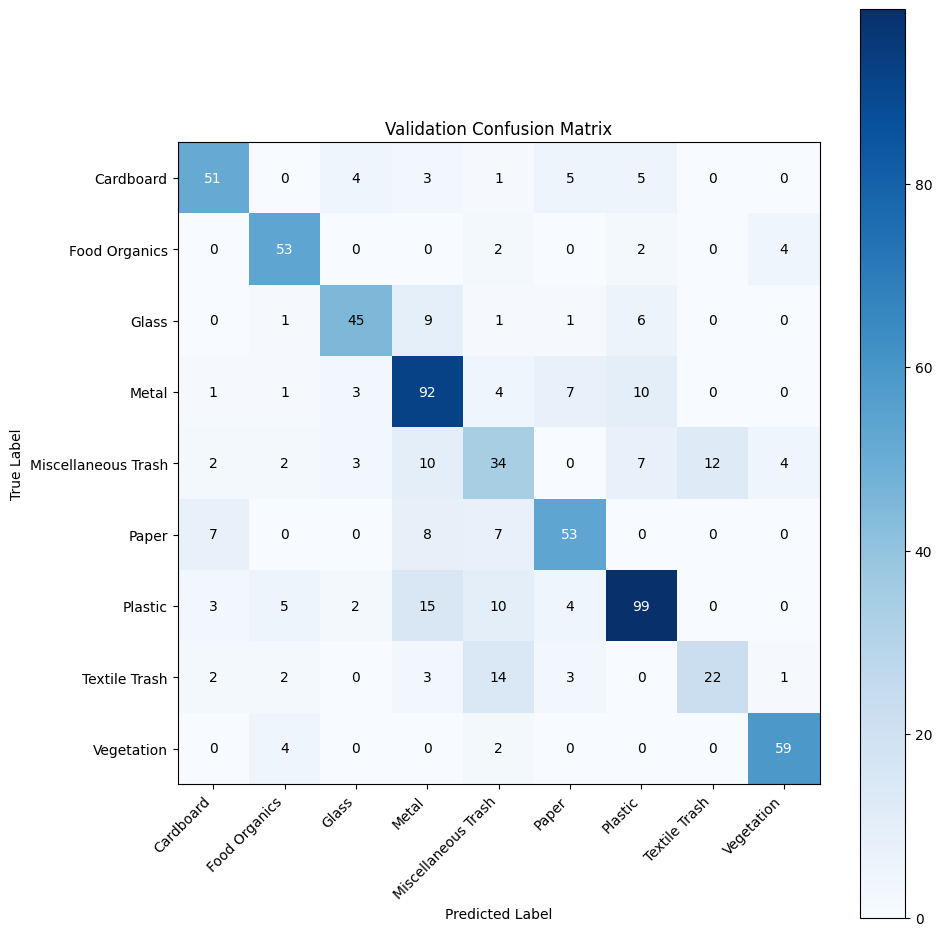

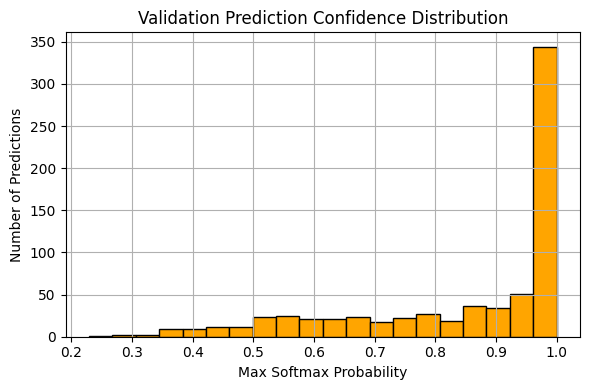

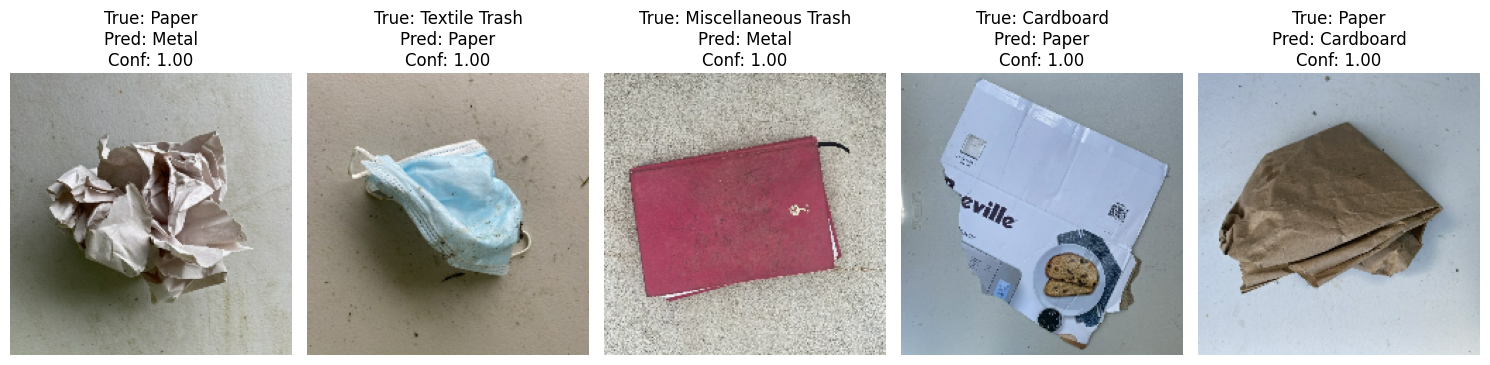

In [ ]:
y_val_true_cnn1, y_val_pred_cnn1 = evaluate_model(
    model=cnn1_model_best,
    dataset=val_ds_cnn1,
    class_names=test_class_names_cnn1,
    title_prefix="Validation"
)


Test Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.74      0.73      0.73        70
      Food Organics       0.76      0.89      0.82        63
              Glass       0.82      0.78      0.80        63
              Metal       0.67      0.70      0.68       119
Miscellaneous Trash       0.64      0.64      0.64        75
              Paper       0.76      0.68      0.72        75
            Plastic       0.65      0.67      0.66       139
      Textile Trash       0.74      0.53      0.62        49
         Vegetation       0.85      0.94      0.89        66

           accuracy                           0.72       719
          macro avg       0.74      0.73      0.73       719
       weighted avg       0.72      0.72      0.72       719



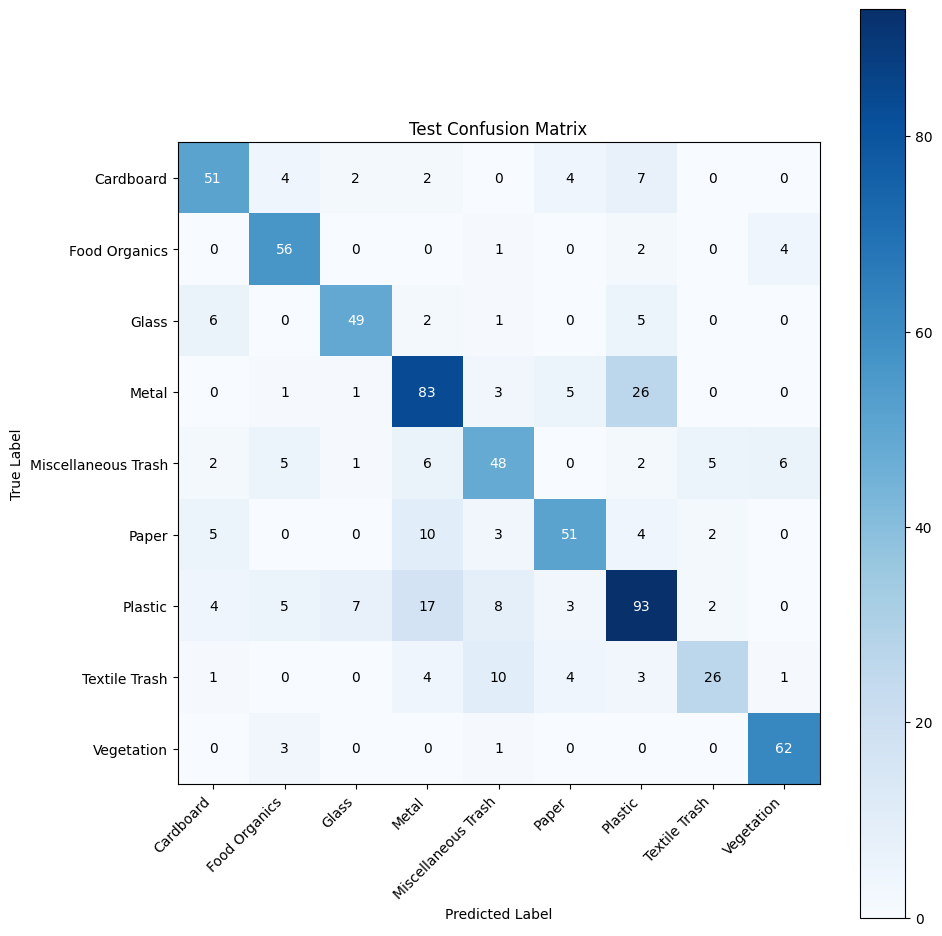

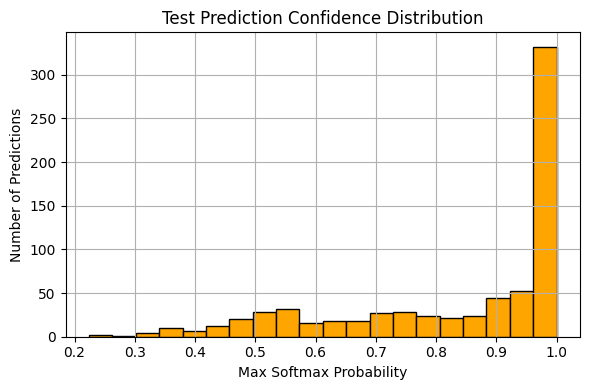

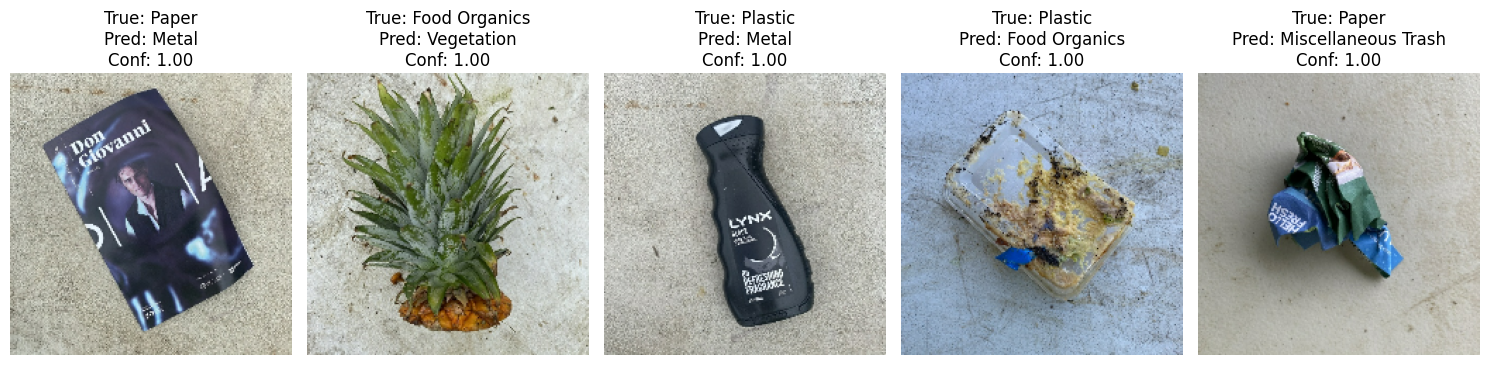

In [ ]:
y_test_true_cnn1, y_test_pred_cnn1 = evaluate_model(
    model=cnn1_model_best,
    dataset=test_ds_cnn1,
    class_names=test_class_names_cnn1,
    title_prefix="Test"
)

# CNN2

- 5 conv layers + BatchNorm + 1 dense layer
  - Add BatchNorm to stabilise training
- Image size - 256x256 - standard size across pretrained models (e.g,MobileNet)
- Batch size - 64 - more stable gradients for GPU training

Use a RandomSearch to find optimal LR, dropout rate and dense layer size


In [ ]:
#Paths and parameters
model_name = 'CNN2'
model_cnn2_path = os.path.join(model_dir, f"{model_name}.keras")

train_cnn2 = augmented_train_folder
val_cnn2 = val_folder
test_cnn2 = test_folder

image_size_cnn2 = (256, 256)
batch_size_cnn2 = 64
epochs_cnn2 = 40

In [ ]:
#Load dataset for CNN2
train_ds_obj_cnn2 = tf.keras.utils.image_dataset_from_directory(
    train_cnn2,
    seed=123,
    image_size=image_size_cnn2,
    batch_size=batch_size_cnn2
)

val_ds_obj_cnn2 = tf.keras.utils.image_dataset_from_directory(
    val_cnn2,
    seed=123,
    image_size=image_size_cnn2,
    batch_size=batch_size_cnn2
)

test_ds_obj_cnn2 = tf.keras.utils.image_dataset_from_directory(
    test_cnn2,
    seed=123,
    image_size=image_size_cnn2,
    batch_size=batch_size_cnn2
)

test_class_names_cnn2 = test_ds_obj_cnn2.class_names
num_classes_cnn2 = len(test_class_names_cnn2)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_cnn2 = (train_ds_obj_cnn2.shuffle(buffer_size=1000).cache().prefetch(buffer_size=AUTOTUNE))
val_ds_cnn2 = val_ds_obj_cnn2.cache().prefetch(AUTOTUNE)
test_ds_cnn2 = test_ds_obj_cnn2.cache().prefetch(AUTOTUNE)

Found 19938 files belonging to 9 classes.
Found 710 files belonging to 9 classes.
Found 719 files belonging to 9 classes.


## Paramter tuning CNN2
- Running RandomSearch to tune parameters for CNN2
  - Learning rate
  - Dense layer size
  - Dropout rate (in dense layer)
- Can run a more extensive search using colab GPU

In [ ]:
def build_model(hp, num_classes):
    model = models.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(256, 256, 3)))

    use_batchnorm = hp.Boolean('use_batchnorm')
    use_l2 = hp.Boolean('use_l2')
    kernel_reg = l2(0.001) if use_l2 else None

    fixed_filters = [16, 32, 64, 128, 256]
    for filters in fixed_filters:
        model.add(layers.Conv2D(filters, kernel_size=3, padding='same', kernel_regularizer=kernel_reg))
        if use_batchnorm:
            model.add(layers.BatchNormalization())
        model.add(layers.Activation('relu'))
        model.add(layers.MaxPooling2D())

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(
        units=hp.Choice('dense_units', [128, 256, 512]),
        activation='relu',
        kernel_regularizer=kernel_reg
    ))

    model.add(layers.Dropout(hp.Float('dropout', 0.3, 0.7, step=0.1)))
    model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=kernel_reg))

    initial_lr = hp.Float('lr', 1e-5, 3e-4, sampling='log')
    lr_schedule = CosineDecay(initial_learning_rate=initial_lr, decay_steps=10000)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

In [ ]:
num_classes = num_classes_cnn2

tuner_cnn2 = kt.RandomSearch(
    lambda hp: build_model(hp, num_classes),
    objective='val_accuracy',
    max_trials=60,
    executions_per_trial=1,
    directory='cnn2_tuning',
    project_name='cnn2_search'
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, "cnn2_tuning_checkpoint.keras"),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

tuner_cnn2.search(
    train_ds_cnn2,
    validation_data=val_ds_cnn2,
    epochs=10,
    callbacks=[checkpoint_cb]
)

# Retrieve and save the best model
best_model = tuner_cnn2.get_best_models(1)[0]
best_model.save(os.path.join(model_dir,"best_cnn2_model.keras"))


Trial 60 Complete [00h 01m 01s]
val_accuracy: 0.5661971569061279

Best val_accuracy So Far: 0.7915493249893188
Total elapsed time: 01h 08m 28s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 49 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
top_models = tuner_cnn2.get_best_models(num_models=5)
top_hps = tuner_cnn2.get_best_hyperparameters(num_trials=5)

for idx, (model, hp) in enumerate(zip(top_models, top_hps)):
    print(f"\n Top Model #{idx + 1} Hyperparameters:")
    print(f"- Dense units: {hp.get('dense_units')}")
    print(f"- Dropout rate: {hp.get('dropout')}")
    print(f"- Learning rate: {hp.get('lr')}")
    print(f"- BatchNormalization: {'Yes' if hp.get('use_batchnorm') else 'No'}")
    print(f"- L2 Regularization: {'Yes' if hp.get('use_l2') else 'No'}")


 Top Model #1 Hyperparameters:
- Dense units: 256
- Dropout rate: 0.3
- Learning rate: 0.00022941961457097345
- BatchNormalization: Yes
- L2 Regularization: Yes

 Top Model #2 Hyperparameters:
- Dense units: 512
- Dropout rate: 0.3
- Learning rate: 7.924906688631832e-05
- BatchNormalization: Yes
- L2 Regularization: Yes

 Top Model #3 Hyperparameters:
- Dense units: 256
- Dropout rate: 0.3
- Learning rate: 0.00018360998687343
- BatchNormalization: Yes
- L2 Regularization: Yes

 Top Model #4 Hyperparameters:
- Dense units: 128
- Dropout rate: 0.6000000000000001
- Learning rate: 0.00013038663192070516
- BatchNormalization: Yes
- L2 Regularization: Yes

 Top Model #5 Hyperparameters:
- Dense units: 128
- Dropout rate: 0.3
- Learning rate: 0.00018104815375065813
- BatchNormalization: Yes
- L2 Regularization: No


## CNN2 Model
- Using params from RandomSearch and running for 40 epochs (with early stopping)


In [ ]:
lr_schedule_cnn2 = CosineDecay(initial_learning_rate=0.0002,decay_steps=10000)
optimizer_cnn2 = tf.keras.optimizers.Adam(learning_rate=lr_schedule_cnn2)

In [ ]:
#Model
cnn2_model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(image_size_cnn2[0],image_size_cnn2[1], 3)),

    layers.Conv2D(16, 3, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(32, 3, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(64, 3, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(128, 3, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.Conv2D(256, 3, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),

    layers.Dense(256, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dropout(0.3),
    layers.Dense(num_classes_cnn2, kernel_regularizer=l2(0.001))
])

cnn2_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 256, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_5 (Activation)       │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 128, 128, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_6 (Activation)       │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_7 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 32, 32, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_8 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 16, 16, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 16, 16, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_9 (Activation)       │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 8, 8, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │             

 Total params: 462,697 (1.77 MB)

 Trainable params: 461,705 (1.76 MB)

 Non-trainable params: 992 (3.88 KB)

In [ ]:
#Compile
cnn2_model.compile(
    optimizer=optimizer_cnn2,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Class weights
class_weight_cnn2 = compute_class_weights_from_dataset(train_ds_cnn2)
print("Class weights:", class_weight_cnn2)

Class weights: {6: 0.5733264320220842, 3: 0.6676712879244525, 4: 1.067116249197174, 0: 1.1466528640441684, 2: 1.2558578987150415, 1: 1.286488579171506, 5: 1.0549206349206348, 8: 1.2105646630236795, 7: 1.6631631631631631}


In [ ]:
#Callbacks
cb_cnn2 = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(
        filepath=model_cnn2_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1)
]

In [ ]:
#Fit the model
history_cnn2 = cnn2_model.fit(train_ds_cnn2, validation_data=val_ds_cnn2, epochs=epochs_cnn2, callbacks=cb_cnn2, class_weight=class_weight_cnn2)

Epoch 1/40
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4035 - loss: 2.1735
Epoch 1: val_accuracy improved from -inf to 0.16620, saving model to /content/data/Models/CNN2.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.4043 - loss: 2.1710 - val_accuracy: 0.1662 - val_loss: 3.7969
Epoch 2/40
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.5974 - loss: 1.5898
Epoch 2: val_accuracy improved from 0.16620 to 0.53662, saving model to /content/data/Models/CNN2.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.5974 - loss: 1.5895 - val_accuracy: 0.5366 - val_loss: 1.7454
Epoch 3/40
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6570 - loss: 1.4059
Epoch 3: val_accuracy improved from 0.53662 to 0.56761, saving model to /content/data/Models/CNN2.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6571 - loss: 1.4057 - val_accuracy: 0.5676 - val_loss: 1.7226
Epoch 4/40
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7011 - l

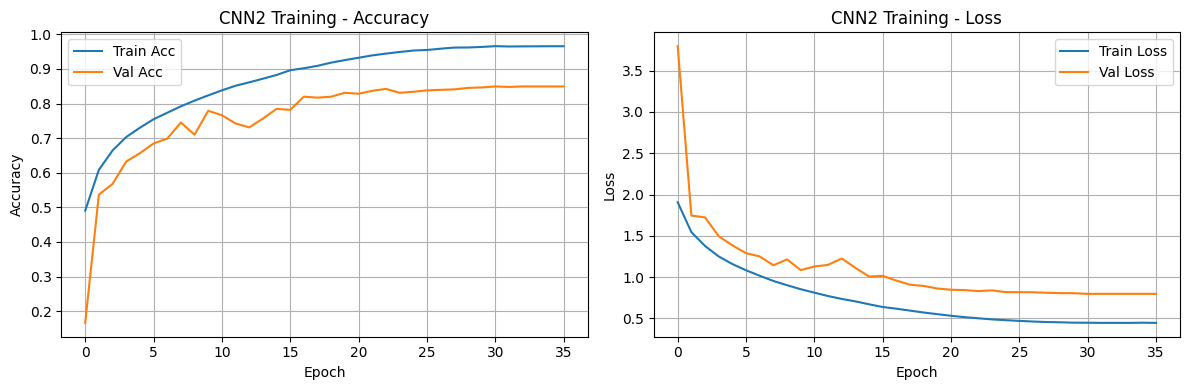

In [ ]:
plot_training_history(history_cnn2, title="CNN2 Training")

### CNN2 evaluation


In [ ]:
cnn2_model_best = load_model(model_cnn2_path)


Validation Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.86      0.90      0.88        69
      Food Organics       0.92      0.89      0.90        61
              Glass       0.82      0.87      0.85        63
              Metal       0.87      0.84      0.85       118
Miscellaneous Trash       0.74      0.62      0.68        74
              Paper       0.84      0.91      0.87        75
            Plastic       0.86      0.87      0.87       138
      Textile Trash       0.78      0.74      0.76        47
         Vegetation       0.89      0.97      0.93        65

           accuracy                           0.85       710
          macro avg       0.84      0.85      0.84       710
       weighted avg       0.85      0.85      0.85       710



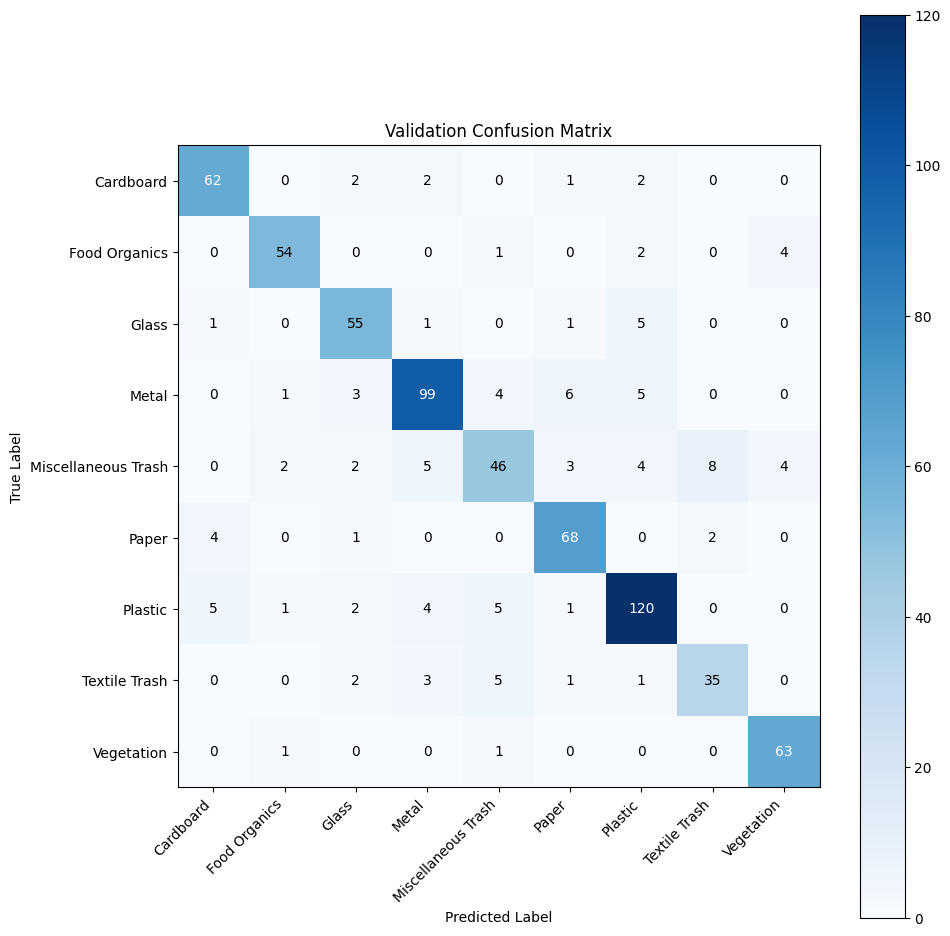

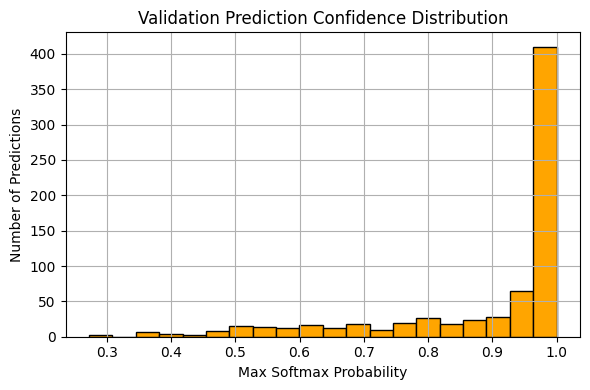

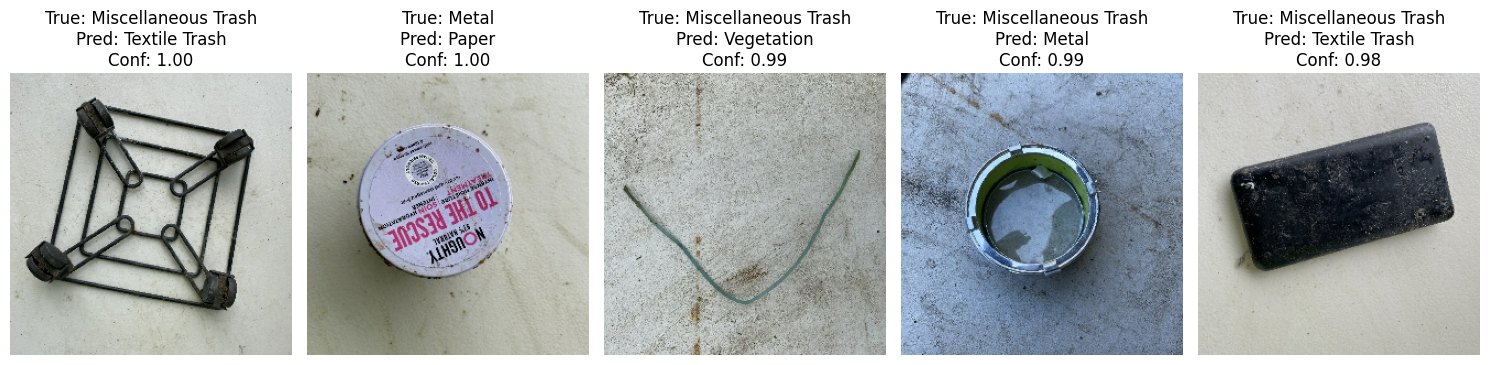

In [ ]:
#Validation set evaluation
y_val_true_cnn2, y_val_pred_cnn2 = evaluate_model(
    model=cnn2_model_best,
    dataset=val_ds_cnn2,
    class_names=test_class_names_cnn2,
    title_prefix="Validation"
)


Test Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.88      0.94      0.91        70
      Food Organics       0.84      0.89      0.86        63
              Glass       0.94      0.95      0.94        63
              Metal       0.82      0.86      0.84       119
Miscellaneous Trash       0.81      0.75      0.78        75
              Paper       0.86      0.85      0.86        75
            Plastic       0.86      0.83      0.84       139
      Textile Trash       0.93      0.76      0.83        49
         Vegetation       0.87      0.94      0.91        66

           accuracy                           0.86       719
          macro avg       0.87      0.86      0.86       719
       weighted avg       0.86      0.86      0.86       719



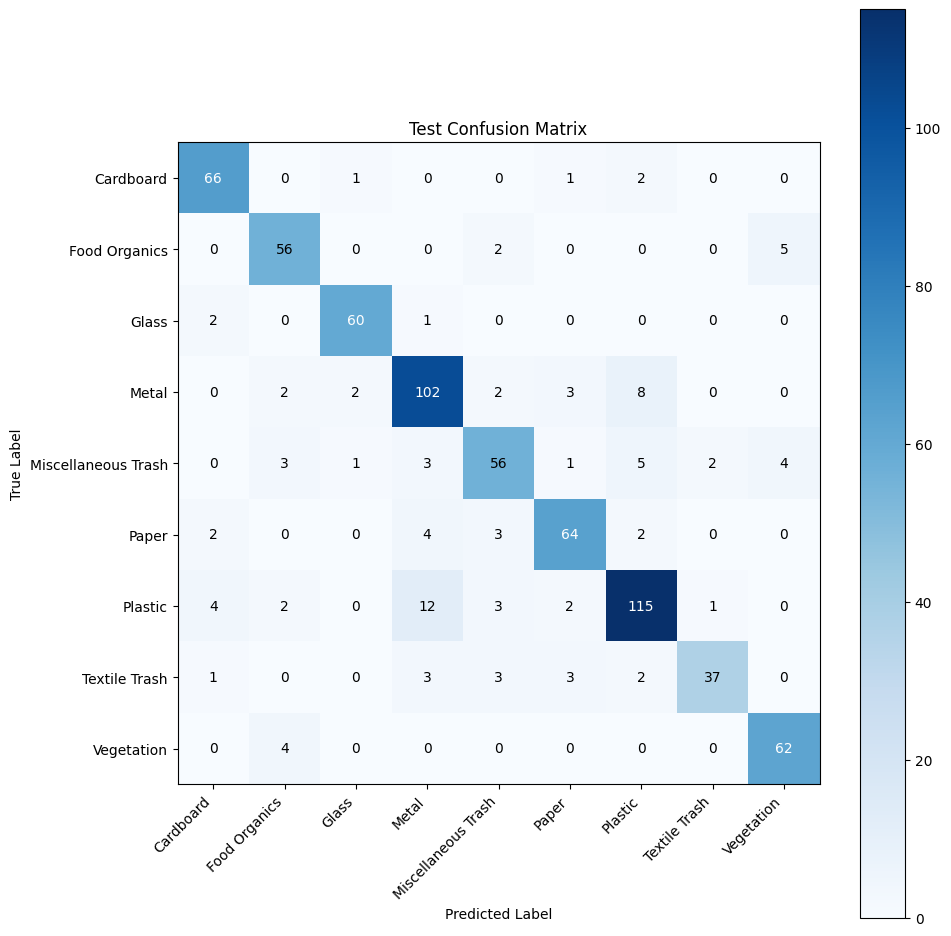

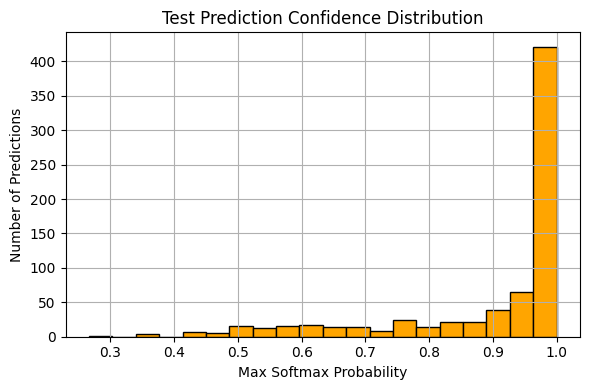

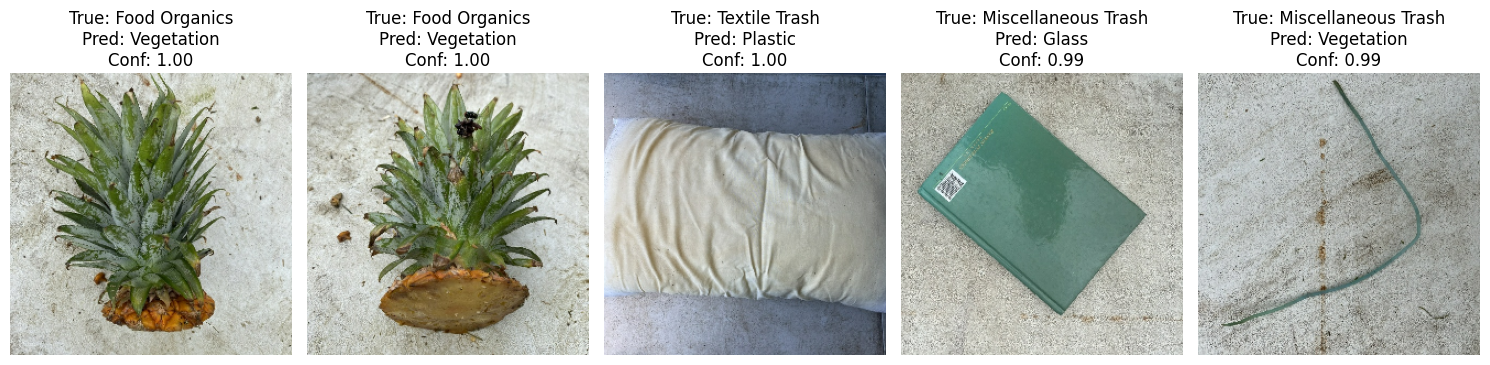

In [ ]:
#Test set evaluation
y_test_true_cnn2, y_test_pred_cnn2 = evaluate_model(
    model=cnn2_model_best,
    dataset=test_ds_cnn2,
    class_names=test_class_names_cnn2,
    title_prefix="Test"
)

# CNN3 - Using depthwise-separable convultion
- Using depthwise separable convultion to compare computational efficiency to CNN2
- Run RS to get best params

In [ ]:
#Paths and parameters
model_name = 'CNN3'
model_cnn3_path = os.path.join(model_dir, f"{model_name}.keras")

train_cnn3 = augmented_train_folder
val_cnn3 = val_folder
test_cnn3 = test_folder

image_size_cnn3 = (256, 256)
batch_size_cnn3 = 64
epochs_cnn3 = 40

In [ ]:
#Load dataset for CNN3
train_ds_obj_cnn3 = tf.keras.utils.image_dataset_from_directory(
    train_cnn3,
    seed=123,
    image_size=image_size_cnn3,
    batch_size=batch_size_cnn3
)

val_ds_obj_cnn3 = tf.keras.utils.image_dataset_from_directory(
    val_cnn3,
    seed=123,
    image_size=image_size_cnn3,
    batch_size=batch_size_cnn3
)

test_ds_obj_cnn3 = tf.keras.utils.image_dataset_from_directory(
    test_cnn3,
    seed=123,
    image_size=image_size_cnn3,
    batch_size=batch_size_cnn3
)

test_class_names_cnn3 = test_ds_obj_cnn3.class_names
num_classes_cnn3 = len(test_class_names_cnn3)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_cnn3 = (train_ds_obj_cnn3.shuffle(buffer_size=1000).cache().prefetch(buffer_size=AUTOTUNE))
val_ds_cnn3 = val_ds_obj_cnn3.cache().prefetch(AUTOTUNE)
test_ds_cnn3 = test_ds_obj_cnn3.cache().prefetch(AUTOTUNE)

Found 19938 files belonging to 9 classes.
Found 710 files belonging to 9 classes.
Found 719 files belonging to 9 classes.


## Param tuning CNN3

In [ ]:
def build_model_depthwise(hp, num_classes):
    model = models.Sequential()
    model.add(layers.Rescaling(1./255, input_shape=(256, 256, 3)))

    use_batchnorm = hp.Boolean('use_batchnorm')
    use_l2 = hp.Boolean('use_l2')
    kernel_reg = l2(0.001) if use_l2 else None

    filters_list = [16, 32, 64, 128, 256]
    for filters in filters_list:
      if kernel_reg:
          model.add(layers.DepthwiseConv2D(kernel_size=3, padding='same'))
      else:
          model.add(layers.DepthwiseConv2D(kernel_size=3, padding='same'))

      if use_batchnorm:
          model.add(layers.BatchNormalization())
      model.add(layers.Activation('relu'))

      # Pointwise conv
      if kernel_reg:
          model.add(layers.Conv2D(filters, kernel_size=1, padding='same', kernel_regularizer=kernel_reg))
      else:
          model.add(layers.Conv2D(filters, kernel_size=1, padding='same'))

      if use_batchnorm:
          model.add(layers.BatchNormalization())
      model.add(layers.Activation('relu'))

      model.add(layers.MaxPooling2D())

    model.add(layers.GlobalAveragePooling2D())

    model.add(layers.Dense(
        units=hp.Choice('dense_units', [128, 256, 512]),
        activation='relu',
        kernel_regularizer=kernel_reg
    ))

    model.add(layers.Dropout(
        rate=hp.Float('dropout', 0.3, 0.7, step=0.1)
    ))

    model.add(layers.Dense(num_classes, activation='softmax', kernel_regularizer=kernel_reg))

    initial_lr = hp.Float('lr', 1e-5, 3e-4, sampling='log')
    lr_schedule = CosineDecay(initial_learning_rate=initial_lr, decay_steps=10000)

    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model


In [ ]:
num_classes = num_classes_cnn3

tuner_cnn3 = kt.RandomSearch(
    lambda hp: build_model_depthwise(hp, num_classes),
    objective='val_accuracy',
    max_trials=80,
    executions_per_trial=1,
    directory='cnn3_tuning',
    project_name='cnn3_search'
)

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    filepath=os.path.join(model_dir, "cnn3_tuning_checkpoint.keras"),
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

tuner_cnn3.search(
    train_ds_cnn3,
    validation_data=val_ds_cnn3,
    epochs=10,
    callbacks=[checkpoint_cb]
)

# Save the best model found
best_model = tuner_cnn3.get_best_models(1)[0]
best_model.save(os.path.join(model_dir, "best_cnn3_model.keras"))

Trial 80 Complete [00h 01m 12s]
val_accuracy: 0.1943662017583847

Best val_accuracy So Far: 0.7450703978538513
Total elapsed time: 01h 46m 48s


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 1 variables whereas the saved optimizer has 89 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
top_models = tuner_cnn3.get_best_models(num_models=5)
top_hps = tuner_cnn3.get_best_hyperparameters(num_trials=5)

for idx, (model, hp) in enumerate(zip(top_models, top_hps)):
    print(f"\n Top Model #{idx + 1} Hyperparameters:")
    print(f"- Dense units: {hp.get('dense_units')}")
    print(f"- Dropout rate: {hp.get('dropout')}")
    print(f"- Learning rate: {hp.get('lr')}")
    print(f"- BatchNormalization: {'Yes' if hp.get('use_batchnorm') else 'No'}")
    print(f"- L2 Regularization: {'Yes' if hp.get('use_l2') else 'No'}")


 Top Model #1 Hyperparameters:
- Dense units: 128
- Dropout rate: 0.3
- Learning rate: 0.0002137862915482632
- BatchNormalization: Yes
- L2 Regularization: Yes

 Top Model #2 Hyperparameters:
- Dense units: 256
- Dropout rate: 0.5
- Learning rate: 0.00022136922826396555
- BatchNormalization: Yes
- L2 Regularization: No

 Top Model #3 Hyperparameters:
- Dense units: 128
- Dropout rate: 0.4
- Learning rate: 0.0001841769884240412
- BatchNormalization: Yes
- L2 Regularization: Yes

 Top Model #4 Hyperparameters:
- Dense units: 512
- Dropout rate: 0.3
- Learning rate: 0.00016776391071797662
- BatchNormalization: Yes
- L2 Regularization: Yes

 Top Model #5 Hyperparameters:
- Dense units: 512
- Dropout rate: 0.6000000000000001
- Learning rate: 0.0002483912092688797
- BatchNormalization: Yes
- L2 Regularization: Yes


## CNN3 Model
- Use parameters from tuning and running for 40 epochs (with early stopping)



In [ ]:
lr_schedule_cnn3 = CosineDecay(initial_learning_rate=0.0002,decay_steps=10000)
optimizer_cnn3 = tf.keras.optimizers.Adam(learning_rate=lr_schedule_cnn3)

In [ ]:
cnn3_model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(256, 256, 3)),

    layers.DepthwiseConv2D(3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(16, 1, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.DepthwiseConv2D(3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(32, 1, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.DepthwiseConv2D(3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(64, 1, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.DepthwiseConv2D(3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(128, 1, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.DepthwiseConv2D(3, padding='same'),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.Conv2D(256, 1, padding='same', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Activation('relu'),
    layers.MaxPooling2D(),

    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.3),
    layers.Dense(num_classes_cnn3)
])

cnn3_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d                │ (None, 256, 256, 3)    │            30 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_10          │ (None, 256, 256, 3)    │            12 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_10 (Activation)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 256, 256, 16)   │            64 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_11          │ (None, 256, 256, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_11 (Activation)      │ (None, 256, 256, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_1              │ (None, 128, 128, 16)   │           160 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_12          │ (None, 128, 128, 16)   │            64 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_12 (Activation)      │ (None, 128, 128, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 128, 128, 32)   │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_13          │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_13 (Activation)      │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ depthwise_conv2d_2              │ (None, 64, 64, 32)     │           320 │
│ (DepthwiseConv2D)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 64, 64, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_14 (Activation)      │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 64, 64, 64)     │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 64, 64, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 83,507 (326.20 KB)

 Trainable params: 82,029 (320.43 KB)

 Non-trainable params: 1,478 (5.77 KB)

In [ ]:
#Compile
cnn3_model.compile(
    optimizer=optimizer_cnn3,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [ ]:
#Class weights
class_weight_cnn3 = compute_class_weights_from_dataset(train_ds_cnn3)
print("Class weights:", class_weight_cnn3)

Class weights: {3: 0.6676712879244525, 8: 1.2105646630236795, 1: 1.286488579171506, 6: 0.5733264320220842, 7: 1.6631631631631631, 0: 1.1466528640441684, 4: 1.067116249197174, 2: 1.2558578987150415, 5: 1.0549206349206348}


In [ ]:
#Callbacks
cb_cnn3 = [
    callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1),
    callbacks.ModelCheckpoint(
        filepath=model_cnn3_path,
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1)
]

In [ ]:
#Fit the model
history_cnn3 = cnn3_model.fit(train_ds_cnn3, validation_data=val_ds_cnn3, epochs=epochs_cnn3, callbacks=cb_cnn3, class_weight=class_weight_cnn3)

Epoch 1/40
311/312 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step - accuracy: 0.2707 - loss: 2.2792
Epoch 1: val_accuracy improved from -inf to 0.08873, saving model to /content/data/Models/CNN3.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.2712 - loss: 2.2777 - val_accuracy: 0.0887 - val_loss: 3.0304
Epoch 2/40
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.4670 - loss: 1.6963
Epoch 2: val_accuracy improved from 0.08873 to 0.45634, saving model to /content/data/Models/CNN3.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.4672 - loss: 1.6956 - val_accuracy: 0.4563 - val_loss: 1.7485
Epoch 3/40
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5432 - loss: 1.4823
Epoch 3: val_accuracy improved from 0.45634 to 0.61268, saving model to /content/data/Models/CNN3.keras
312/312 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - accuracy: 0.5434 - loss: 1.4819 - val_accuracy: 0.6127 - val_loss: 1.3347
Epoch 4/40
310/312 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.5825 - l

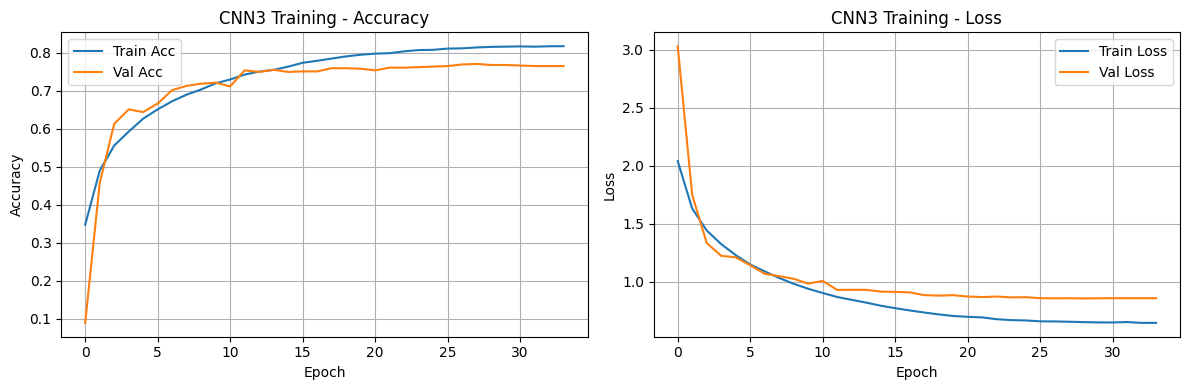

In [ ]:
plot_training_history(history_cnn3, title="CNN3 Training")

## CNN3 evaluation

In [ ]:
cnn3_model_best = load_model(model_cnn3_path)


Validation CNN3 Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.73      0.80      0.76        69
      Food Organics       0.81      0.82      0.81        61
              Glass       0.75      0.83      0.79        63
              Metal       0.78      0.76      0.77       118
Miscellaneous Trash       0.61      0.61      0.61        74
              Paper       0.75      0.88      0.81        75
            Plastic       0.87      0.73      0.80       138
      Textile Trash       0.70      0.60      0.64        47
         Vegetation       0.86      0.92      0.89        65

           accuracy                           0.77       710
          macro avg       0.76      0.77      0.76       710
       weighted avg       0.77      0.77      0.77       710



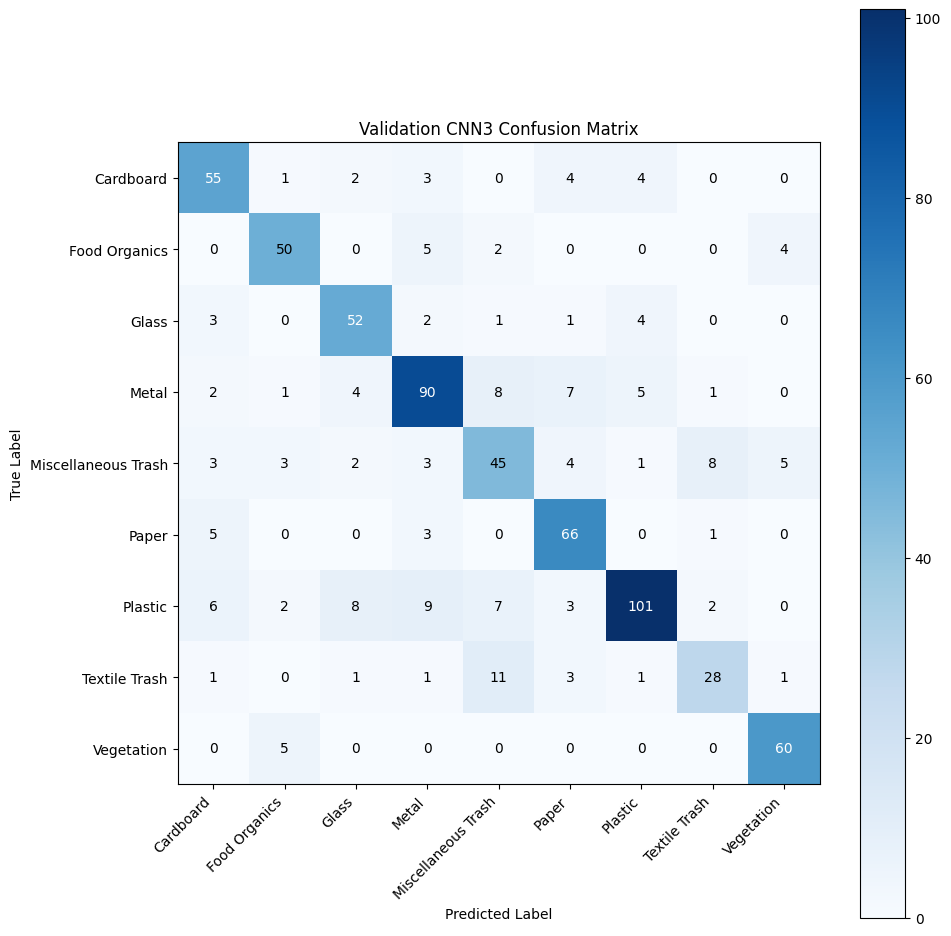

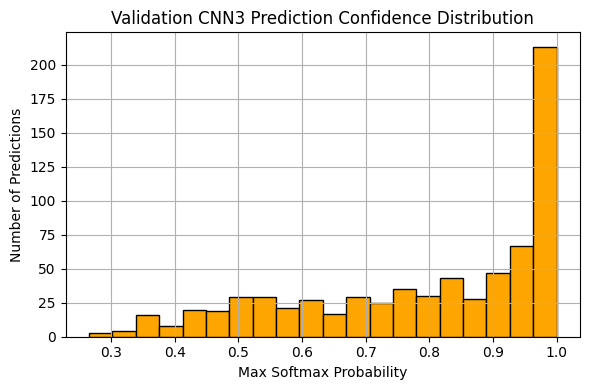

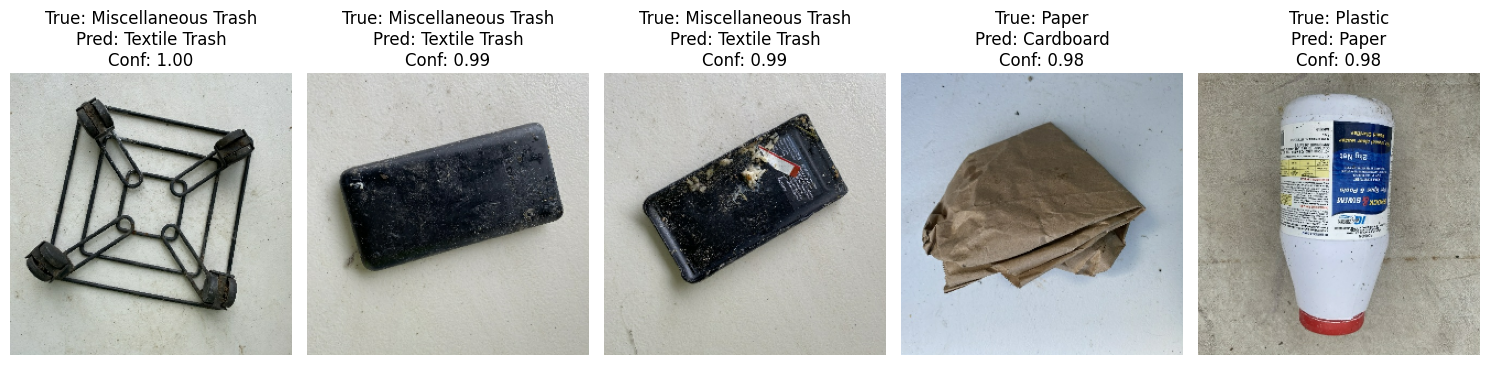

In [ ]:
#Validation set evaluation
y_val_true_cnn3, y_val_pred_cnn3 = evaluate_model(
    model=cnn3_model_best,
    dataset=val_ds_cnn3,
    class_names=test_class_names_cnn3,
    title_prefix="Validation CNN3"
)


Test CNN3 Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.69      0.84      0.76        70
      Food Organics       0.73      0.86      0.79        63
              Glass       0.81      0.87      0.84        63
              Metal       0.77      0.72      0.75       119
Miscellaneous Trash       0.69      0.64      0.66        75
              Paper       0.81      0.77      0.79        75
            Plastic       0.74      0.62      0.67       139
      Textile Trash       0.74      0.71      0.73        49
         Vegetation       0.79      0.89      0.84        66

           accuracy                           0.75       719
          macro avg       0.75      0.77      0.76       719
       weighted avg       0.75      0.75      0.75       719



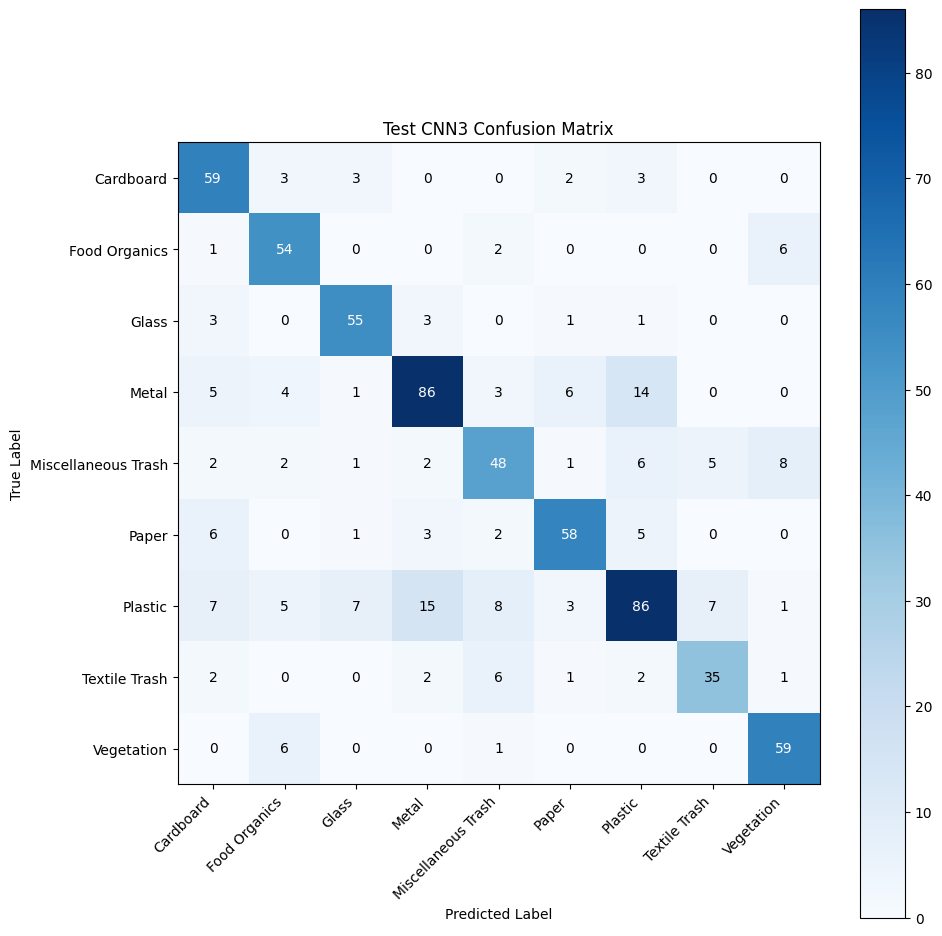

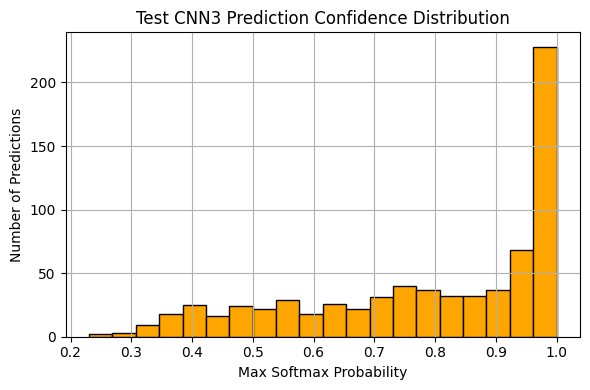

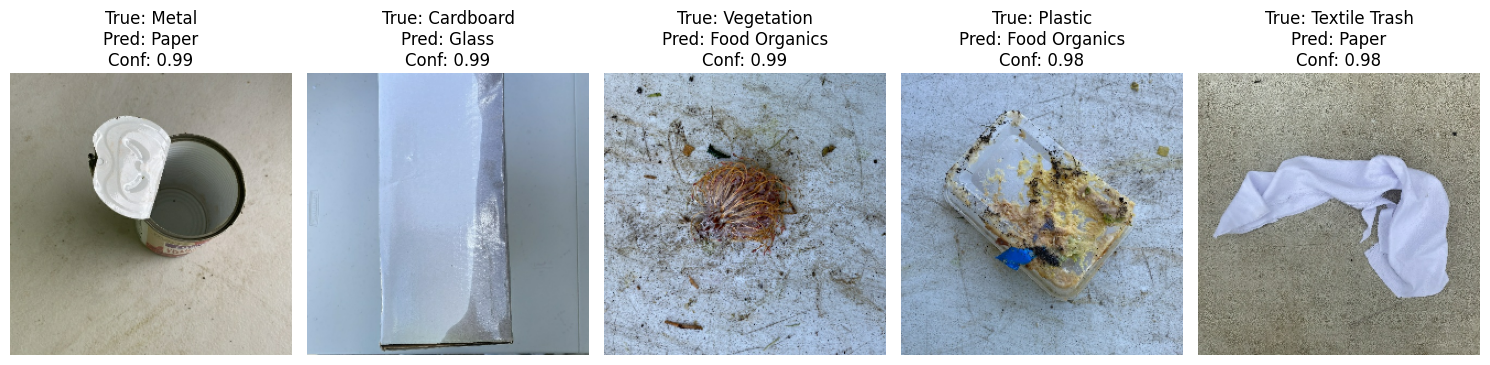

In [ ]:
#Test set evaluation
y_test_true_cnn3, y_test_pred_cnn3 = evaluate_model(
    model=cnn3_model_best,
    dataset=test_ds_cnn3,
    class_names=test_class_names_cnn3,
    title_prefix="Test CNN3"
)

Comaparing computaional efficiency between CNN2 and CNN3

In [ ]:
results = []

results.append(evaluate_cnn_efficiency(cnn2_model_best, "Standard CNN2", test_ds_cnn2))
results.append(evaluate_cnn_efficiency(cnn3_model_best, "Depthwise CNN3", test_ds_cnn3))
df_results = pd.DataFrame(results)
display(df_results)

Model  Accuracy (%)  Parameters (K)  Inference Time (ms)
0   Standard CNN2         85.95          462.70                75.04
1  Depthwise CNN3         75.10           83.51                70.69

# CNN2 with SVM classifier
- Use CNN2 as the feature extractor for SVM

In [ ]:
#Paths and parameters

train_svm2 = augmented_train_folder
val_svm2 = val_folder
test_svm2 = test_folder

cnn_path = model_cnn2_path #using CNN2
image_size_svm2 = (256, 256)
batch_size_svm2 = 64

In [ ]:
#Load dataset for SVM2
train_ds_obj_svm2 = tf.keras.utils.image_dataset_from_directory(
    train_svm2,
    seed=123,
    image_size=image_size_svm2,
    batch_size=batch_size_svm2
)

val_ds_obj_svm2 = tf.keras.utils.image_dataset_from_directory(
    val_svm2,
    seed=123,
    image_size=image_size_svm2,
    batch_size=batch_size_svm2
)

test_ds_obj_svm2 = tf.keras.utils.image_dataset_from_directory(
    test_cnn2,
    seed=123,
    image_size=image_size_svm2,
    batch_size=batch_size_svm2
)

test_class_names_svm2 = test_ds_obj_svm2.class_names
num_classes_svm2 = len(test_class_names_svm2)

AUTOTUNE = tf.data.AUTOTUNE
train_ds_svm2 = (train_ds_obj_svm2.shuffle(buffer_size=1000).cache().prefetch(buffer_size=AUTOTUNE))
val_ds_svm2 = val_ds_obj_svm2.cache().prefetch(AUTOTUNE)
test_ds_svm2 = test_ds_obj_svm2.cache().prefetch(AUTOTUNE)

Found 19938 files belonging to 9 classes.
Found 710 files belonging to 9 classes.
Found 719 files belonging to 9 classes.


In [ ]:
#Use our best CNN model from before (defined above)
cnn = load_model(cnn_path)

In [ ]:
#Cut the model before the first dense layer
first_dense_ix = next(
    i for i, layer in enumerate(cnn.layers)
    if isinstance(layer, Dense)
)
feature_layers = cnn.layers[:first_dense_ix]

In [ ]:
# Build the feature extractor
inp = Input(shape=(*image_size_svm2, 3))
x   = inp
for layer in feature_layers:
    x = layer(x)
feature_extractor = Model(inputs=inp, outputs=x)

In [ ]:
# Extract features
def extract_features(ds):
    feats, labels = [], []
    for imgs, lbls in ds:
        out = feature_extractor.predict(imgs, verbose=0)
        feats.append(out)
        labels.append(lbls.numpy())
    return np.vstack(feats), np.concatenate(labels)

train_features, train_labels = extract_features(train_ds_svm2)
val_features, val_labels = extract_features(val_ds_svm2)
test_features, test_labels = extract_features(test_ds_svm2)

In [ ]:
#Scale the features
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

In [ ]:
#Grid search for best params
param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [0.001, 0.01, 0.1, 'scale'],
    'kernel': ['rbf'],
    'class_weight': ['balanced']
}

svm = SVC(random_state=123)

grid_search = GridSearchCV(
    estimator=svm,
    param_grid=param_grid,
    scoring='accuracy',
    cv=5,
    verbose=2,
    n_jobs=-1
)

grid_search.fit(train_features, train_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


GridSearchCV(cv=5, estimator=SVC(random_state=123), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 100], 'class_weight': ['balanced'],
                         'gamma': [0.001, 0.01, 0.1, 'scale'],
                         'kernel': ['rbf']},
             scoring='accuracy', verbose=2)

In [ ]:
#Get best model from grid search
svm2 = SVC(C=10, class_weight='balanced', gamma=0.01, kernel='rbf', random_state=123)
svm2.fit(train_features, train_labels)

SVC(C=10, class_weight='balanced', gamma=0.01, random_state=123)

### CNN2+SVM evaluation


Validation Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.88      0.93      0.90        69
      Food Organics       0.95      0.90      0.92        61
              Glass       0.90      0.86      0.88        63
              Metal       0.91      0.86      0.88       118
Miscellaneous Trash       0.79      0.70      0.74        74
              Paper       0.83      0.93      0.88        75
            Plastic       0.86      0.91      0.88       138
      Textile Trash       0.88      0.77      0.82        47
         Vegetation       0.91      0.98      0.95        65

           accuracy                           0.88       710
          macro avg       0.88      0.87      0.87       710
       weighted avg       0.88      0.88      0.87       710



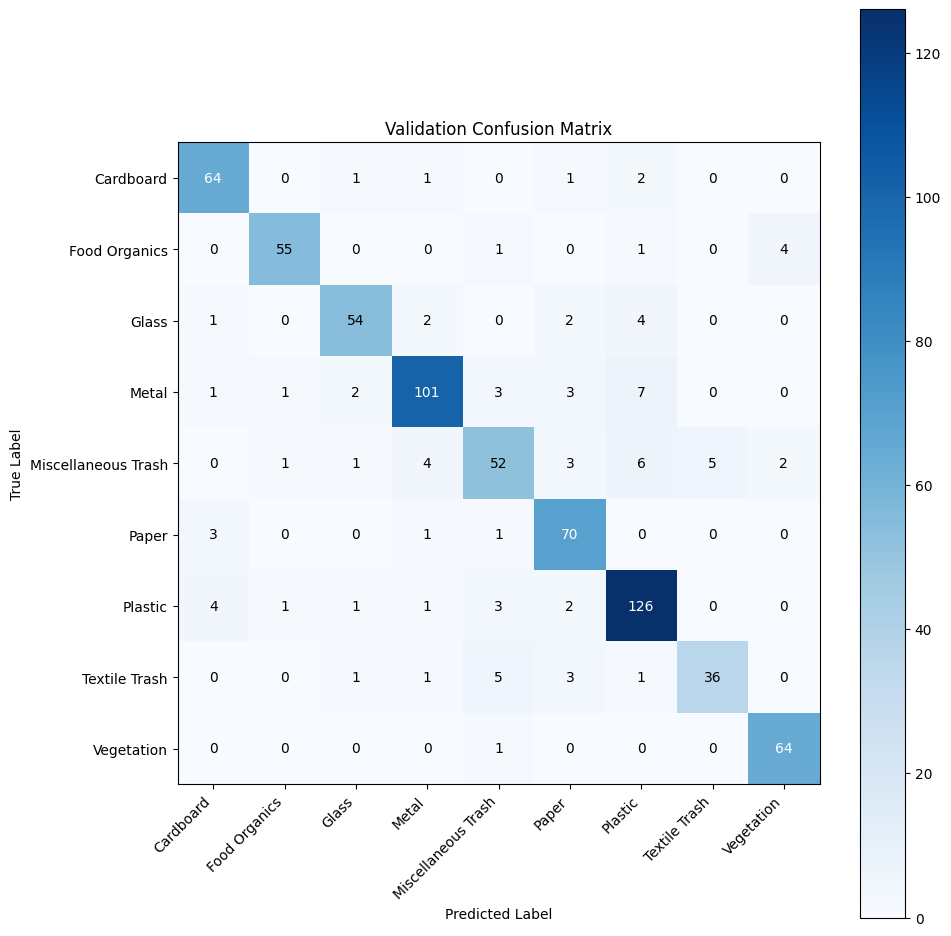

In [ ]:
#Validation set evaluation
evaluate_svm_model(
    model=svm2,
    X=val_features,
    y=val_labels,
    class_names=test_class_names_svm2,
    title_prefix="Validation"
)


SVM2 test Classification Report:
                     precision    recall  f1-score   support

          Cardboard       0.89      0.94      0.92        70
      Food Organics       0.92      0.89      0.90        63
              Glass       1.00      0.94      0.97        63
              Metal       0.87      0.87      0.87       119
Miscellaneous Trash       0.83      0.91      0.87        75
              Paper       0.86      0.93      0.90        75
            Plastic       0.88      0.86      0.87       139
      Textile Trash       1.00      0.78      0.87        49
         Vegetation       0.91      0.95      0.93        66

           accuracy                           0.89       719
          macro avg       0.91      0.90      0.90       719
       weighted avg       0.90      0.89      0.89       719



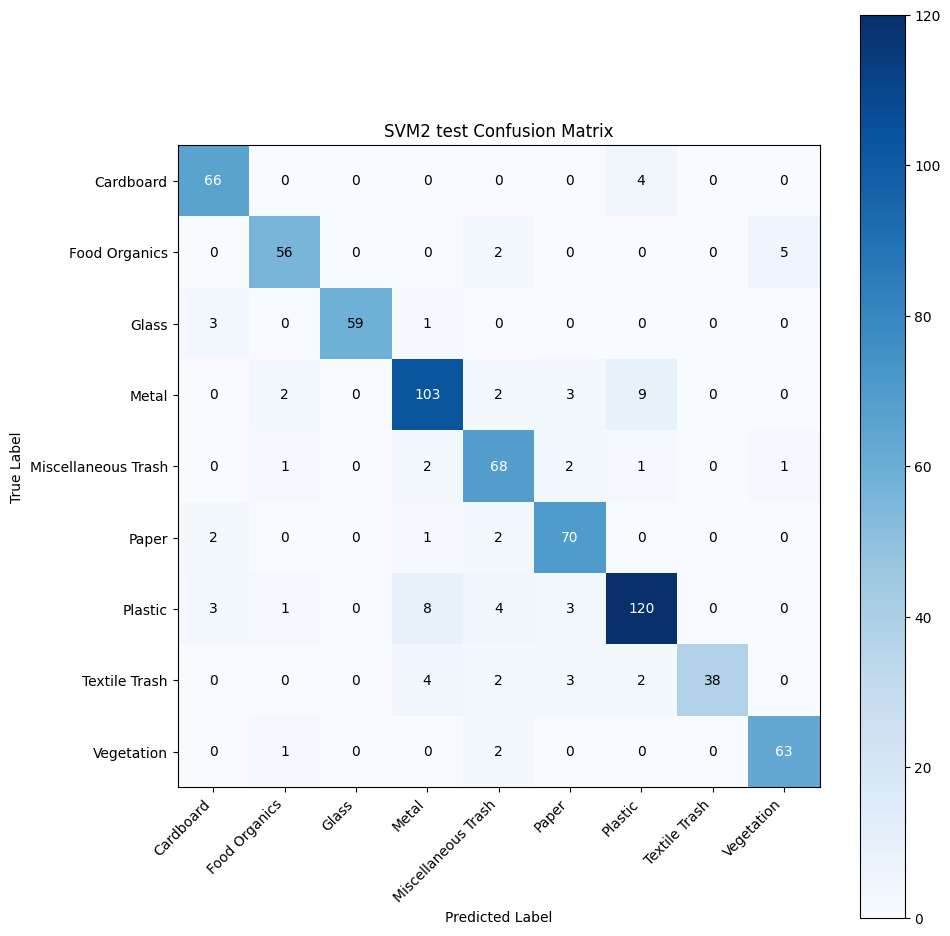

In [ ]:
#Test set evaluation
evaluate_svm_model(
    model=svm2,
    X=test_features,
    y=test_labels,
    class_names=test_class_names_svm2,
    title_prefix="SVM2 test"
)